# KoBERT finetuning

- https://github.com/SKTBrain/KoBERT/issues/102
- https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb
- https://velog.io/@ynk410/한국어를-위한-KoBERT-사용기
- https://blog.naver.com/newyearchive/223097878715

In [1]:
import sys

In [2]:
# !{sys.executable} -m pip install mxnet
# !{sys.executable} -m pip install gluonnlp==0.8.0
# !{sys.executable} -m pip install pandas tqdm sentencepiece
# !{sys.executable} -m pip install transformers # ==3.0.2
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install torch --index-url https://download.pytorch.org/whl/cu117
# !{sys.executable} -m pip install ipywidgets  # for vscode

In [3]:
# !{sys.executable} -m pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
# AttributeError: module 'numpy' has no attribute 'bool'.
# https://stackoverflow.com/questions/74893742/how-to-solve-attributeerror-module-numpy-has-no-attribute-bool
import numpy as np

np.bool = np.bool_

In [5]:
import os

import gluonnlp as nlp
import matplotlib.pyplot as plt
import numpy as np
import torch
from kobert_tokenizer import KoBERTTokenizer
from torch import nn
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AdamW, BertModel
from transformers.optimization import get_cosine_schedule_with_warmup

from kobert import BERTClassifier, BERTDataset, BERTSentenceTransform

/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
PRETRAINED = "skt/kobert-base-v1"

tokenizer = KoBERTTokenizer.from_pretrained(PRETRAINED)
bertmodel = BertModel.from_pretrained(PRETRAINED, return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(
    tokenizer.vocab_file, padding_token="[PAD]"
)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
# https://nlp.gluon.ai/api/modules/data.html#gluonnlp.data.TSVDataset

dataset_train = nlp.data.TSVDataset(
    "./data/intent_answers_Training.tsv", field_indices=[1, 2], num_discard_samples=1
)
dataset_test = nlp.data.TSVDataset(
    "./data/intent_answers_Validation.tsv", field_indices=[1, 2], num_discard_samples=1
)

In [9]:
dataset_train[:3]

[['그리고   그 꿈을 이루기 위해서는 이 회사가 저에게는 가장 적합한 곳이라고 생각했기에 지원을 하게 됐고 여기까지 오지 않았나 생각을 합니다.',
  '7'],
 ['따라서 어떤 문제가 발생했을 때는   다시 일단 멈추고 이게 어떤 분야에서 현재 문제를 어떤 절차에서 어떤 과정에서 발생이 됐는지 또 그 이유가 뭔지를   먼저 파악해 보는 절차를 거치고요.',
  '8'],
 ['두 번째는 파악이 되면 이 문제를   애초에 그 예방할 수 있었던 측면을 다시 생각을 해보고 다음에 프로젝트를 진행할 때는   이 부분을 피해서 갈 요량으로 어떤 정의를 하는 게 하나가 있고 두 번째는 이미 지나왔고 현재 닥친 문제를 해결하기 위해서는 어떤 게 가장 효과적인 조치일까에 대해서   생각해보는 것 같습니다.',
  '8']]

In [10]:
# Setting parameters
max_len = 128
batch_size = 64
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [11]:
tok = tokenizer

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [12]:
train_dataloader = torch.utils.data.DataLoader(
    data_train, batch_size=batch_size, num_workers=5
)
test_dataloader = torch.utils.data.DataLoader(
    data_test, batch_size=batch_size, num_workers=5
)

In [13]:
train_dataloader

In [14]:
# num_classes 수정

model = BERTClassifier(bertmodel, dr_rate=0.5, num_classes=16).to(device)
model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [15]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [16]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/home/j-j10d102/.conda/envs/j10d102/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [18]:
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total
)

In [19]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy() / max_indices.size()[0]
    return train_acc

In [20]:
train_acc_history = []
train_loss_history = []
val_acc_history = []

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print(
                "epoch {} batch id {} loss {} train acc {}".format(
                    e + 1,
                    batch_id + 1,
                    loss.data.cpu().numpy(),
                    train_acc / (batch_id + 1),
                )
            )
            train_acc_history.append(train_acc / (batch_id + 1))
            train_loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e + 1, train_acc / (batch_id + 1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(
        enumerate(test_dataloader), total=len(test_dataloader)
    ):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e + 1, test_acc / (batch_id + 1)))
    val_acc_history.append(test_acc / (batch_id + 1))

  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.733738899230957 train acc 0.125
epoch 1 train acc 0.09579918032786885


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 1 test acc 0.1890625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 2.5782904624938965 train acc 0.234375
epoch 2 train acc 0.1885245901639344


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 2 test acc 0.326171875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.2650609016418457 train acc 0.40625
epoch 3 train acc 0.42751024590163933


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 3 test acc 0.591015625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.6097867488861084 train acc 0.640625
epoch 4 train acc 0.5993852459016393


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 4 test acc 0.62109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.0634286403656006 train acc 0.84375
epoch 5 train acc 0.6941598360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 5 test acc 0.623046875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.7700767517089844 train acc 0.84375
epoch 6 train acc 0.7407786885245902


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 6 test acc 0.637109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.7088621854782104 train acc 0.796875
epoch 7 train acc 0.7617827868852459


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 7 test acc 0.63515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.4960780143737793 train acc 0.875
epoch 8 train acc 0.8183913934426229


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 8 test acc 0.66875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.29885387420654297 train acc 0.953125
epoch 9 train acc 0.8363217213114754


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 9 test acc 0.6609375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.3932141363620758 train acc 0.859375
epoch 10 train acc 0.8478483606557377


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 10 test acc 0.678515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.27493298053741455 train acc 0.921875
epoch 11 train acc 0.8814036885245902


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 11 test acc 0.6609375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.1335003525018692 train acc 0.984375
epoch 12 train acc 0.8985655737704918


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 12 test acc 0.680078125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.19543777406215668 train acc 0.953125
epoch 13 train acc 0.9190573770491803


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 13 test acc 0.687890625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.2900044918060303 train acc 0.90625
epoch 14 train acc 0.9159836065573771


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 14 test acc 0.701171875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.06664823740720749 train acc 1.0
epoch 15 train acc 0.9410860655737705


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 15 test acc 0.735546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.051826972514390945 train acc 1.0
epoch 16 train acc 0.9495389344262295


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 16 test acc 0.7234375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.028546951711177826 train acc 1.0
epoch 17 train acc 0.9654200819672131


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 17 test acc 0.703515625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.013680045492947102 train acc 1.0
epoch 18 train acc 0.9713114754098361


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 18 test acc 0.7671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.012944184243679047 train acc 1.0
epoch 19 train acc 0.9754098360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 19 test acc 0.703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.01809220016002655 train acc 1.0
epoch 20 train acc 0.9754098360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 20 test acc 0.733203125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.015385434031486511 train acc 1.0
epoch 21 train acc 0.9766905737704918


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 21 test acc 0.729296875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.029380256310105324 train acc 0.984375
epoch 22 train acc 0.9815573770491803


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 22 test acc 0.73046875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.009449099190533161 train acc 1.0
epoch 23 train acc 0.9851434426229508


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 23 test acc 0.737109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.012022169306874275 train acc 1.0
epoch 24 train acc 0.9897540983606558


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 24 test acc 0.737109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.005147204268723726 train acc 1.0
epoch 25 train acc 0.9879610655737705


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 25 test acc 0.691796875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.004560430068522692 train acc 1.0
epoch 26 train acc 0.9910348360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 26 test acc 0.74921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.007475991267710924 train acc 1.0
epoch 27 train acc 0.9907786885245902


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 27 test acc 0.7484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.02048981934785843 train acc 0.984375
epoch 28 train acc 0.9910348360655737


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 28 test acc 0.73828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.003073709085583687 train acc 1.0
epoch 29 train acc 0.9938524590163934


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 29 test acc 0.745703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.002927483059465885 train acc 1.0
epoch 30 train acc 0.9959016393442623


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 30 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.012522852048277855 train acc 1.0
epoch 31 train acc 0.9956454918032787


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 31 test acc 0.75703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.0020987396128475666 train acc 1.0
epoch 32 train acc 0.9971823770491803


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 32 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.00143816031049937 train acc 1.0
epoch 33 train acc 0.9982069672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 33 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.0625937283039093 train acc 0.984375
epoch 34 train acc 0.9982069672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 34 test acc 0.77265625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.020794762298464775 train acc 0.984375
epoch 35 train acc 0.9964139344262295


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 35 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.0009399595437571406 train acc 1.0
epoch 36 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 36 test acc 0.75234375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.0009692255407571793 train acc 1.0
epoch 37 train acc 0.9979508196721312


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 37 test acc 0.741015625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.0009403587901033461 train acc 1.0
epoch 38 train acc 0.9982069672131147


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 38 test acc 0.75703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.06925662606954575 train acc 0.984375
epoch 39 train acc 0.9976946721311475


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 39 test acc 0.77421875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.0006990949623286724 train acc 1.0
epoch 40 train acc 0.9974385245901639


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 40 test acc 0.746484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.0007088332786224782 train acc 1.0
epoch 41 train acc 0.9971823770491803


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 41 test acc 0.74296875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.0006581238121725619 train acc 1.0
epoch 42 train acc 0.9992315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 42 test acc 0.734765625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.0009814812801778316 train acc 1.0
epoch 43 train acc 0.9989754098360656


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 43 test acc 0.746484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.0006049820804037154 train acc 1.0
epoch 44 train acc 0.9992315573770492


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 44 test acc 0.75859375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.000561232736799866 train acc 1.0
epoch 45 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 45 test acc 0.738671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.0005126086762174964 train acc 1.0
epoch 46 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 46 test acc 0.742578125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.0005547903710976243 train acc 1.0
epoch 47 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 47 test acc 0.754296875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.0008142288425005972 train acc 1.0
epoch 48 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 48 test acc 0.75234375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.00044389526010490954 train acc 1.0
epoch 49 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 49 test acc 0.752734375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.0003865527978632599 train acc 1.0
epoch 50 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 50 test acc 0.762890625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 0.0004609492898453027 train acc 1.0
epoch 51 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 51 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.00038248286000452936 train acc 1.0
epoch 52 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 52 test acc 0.744921875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 0.0003855881514027715 train acc 1.0
epoch 53 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 53 test acc 0.73671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 54 batch id 1 loss 0.00037911711842752993 train acc 1.0
epoch 54 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 54 test acc 0.740625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 55 batch id 1 loss 0.0002772909065242857 train acc 1.0
epoch 55 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 55 test acc 0.742578125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 56 batch id 1 loss 0.0002792043669614941 train acc 1.0
epoch 56 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 56 test acc 0.748828125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 57 batch id 1 loss 0.0002943519502878189 train acc 1.0
epoch 57 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 57 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 58 batch id 1 loss 0.00025377440033480525 train acc 1.0
epoch 58 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 58 test acc 0.746484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 59 batch id 1 loss 0.00026931631145998836 train acc 1.0
epoch 59 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 59 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 60 batch id 1 loss 0.00023167762265074998 train acc 1.0
epoch 60 train acc 0.9994877049180327


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 60 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 61 batch id 1 loss 0.0002765014360193163 train acc 1.0
epoch 61 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 61 test acc 0.7765625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 62 batch id 1 loss 0.00024463346926495433 train acc 1.0
epoch 62 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 62 test acc 0.78203125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 63 batch id 1 loss 0.00022481345513369888 train acc 1.0
epoch 63 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 63 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 64 batch id 1 loss 0.00019990859436802566 train acc 1.0
epoch 64 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 64 test acc 0.758984375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 65 batch id 1 loss 0.00022391925449483097 train acc 1.0
epoch 65 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 65 test acc 0.7671875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 66 batch id 1 loss 0.00022373307729139924 train acc 1.0
epoch 66 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 66 test acc 0.775


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 67 batch id 1 loss 0.0002389340806985274 train acc 1.0
epoch 67 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 67 test acc 0.77109375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 68 batch id 1 loss 0.00020289731037337333 train acc 1.0
epoch 68 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 68 test acc 0.77265625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 69 batch id 1 loss 0.00020103645510971546 train acc 1.0
epoch 69 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 69 test acc 0.77265625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 70 batch id 1 loss 0.00018283913959749043 train acc 1.0
epoch 70 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 70 test acc 0.77265625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 71 batch id 1 loss 0.000184616117621772 train acc 1.0
epoch 71 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 71 test acc 0.770703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 72 batch id 1 loss 0.0001679212728049606 train acc 1.0
epoch 72 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 72 test acc 0.770703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 73 batch id 1 loss 0.0002006845606956631 train acc 1.0
epoch 73 train acc 0.9997438524590164


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 73 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 74 batch id 1 loss 0.00019457159214653075 train acc 1.0
epoch 74 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 74 test acc 0.758984375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 75 batch id 1 loss 0.00015105029160622507 train acc 1.0
epoch 75 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 75 test acc 0.75703125


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 76 batch id 1 loss 0.00018069766520056874 train acc 1.0
epoch 76 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 76 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 77 batch id 1 loss 0.0001646509044803679 train acc 1.0
epoch 77 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 77 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 78 batch id 1 loss 0.0001853017893154174 train acc 1.0
epoch 78 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 78 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 79 batch id 1 loss 0.00016944749222602695 train acc 1.0
epoch 79 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 79 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 80 batch id 1 loss 0.00021045608446002007 train acc 1.0
epoch 80 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 80 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 81 batch id 1 loss 0.00016199462697841227 train acc 1.0
epoch 81 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 81 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 82 batch id 1 loss 0.00017722707707434893 train acc 1.0
epoch 82 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 82 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 83 batch id 1 loss 0.00014813078450970352 train acc 1.0
epoch 83 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 83 test acc 0.76484375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 84 batch id 1 loss 0.0001405488874297589 train acc 1.0
epoch 84 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 84 test acc 0.766796875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 85 batch id 1 loss 0.00014039012603461742 train acc 1.0
epoch 85 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 85 test acc 0.766796875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 86 batch id 1 loss 0.00015116283611860126 train acc 1.0
epoch 86 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 86 test acc 0.756640625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 87 batch id 1 loss 0.00018635181186255068 train acc 1.0
epoch 87 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 87 test acc 0.75859375


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 88 batch id 1 loss 0.00014358201588038355 train acc 1.0
epoch 88 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 88 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 89 batch id 1 loss 0.00013823942572344095 train acc 1.0
epoch 89 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 89 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 90 batch id 1 loss 0.00015073601389303803 train acc 1.0
epoch 90 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 90 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 91 batch id 1 loss 0.00014467581058852375 train acc 1.0
epoch 91 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 91 test acc 0.760546875


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 92 batch id 1 loss 0.00014537310926243663 train acc 1.0
epoch 92 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 92 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 93 batch id 1 loss 0.00017503155686426908 train acc 1.0
epoch 93 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 93 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 94 batch id 1 loss 0.00014008875587023795 train acc 1.0
epoch 94 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 94 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 95 batch id 1 loss 0.00014596316032111645 train acc 1.0
epoch 95 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 95 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 96 batch id 1 loss 0.00014780662604607642 train acc 1.0
epoch 96 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 96 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 97 batch id 1 loss 0.00013629032764583826 train acc 1.0
epoch 97 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 97 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 98 batch id 1 loss 0.0001441364292986691 train acc 1.0
epoch 98 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 98 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 99 batch id 1 loss 0.000132644985569641 train acc 1.0
epoch 99 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 99 test acc 0.7625


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 100 batch id 1 loss 0.00013952354493085295 train acc 1.0
epoch 100 train acc 1.0


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 100 test acc 0.7625


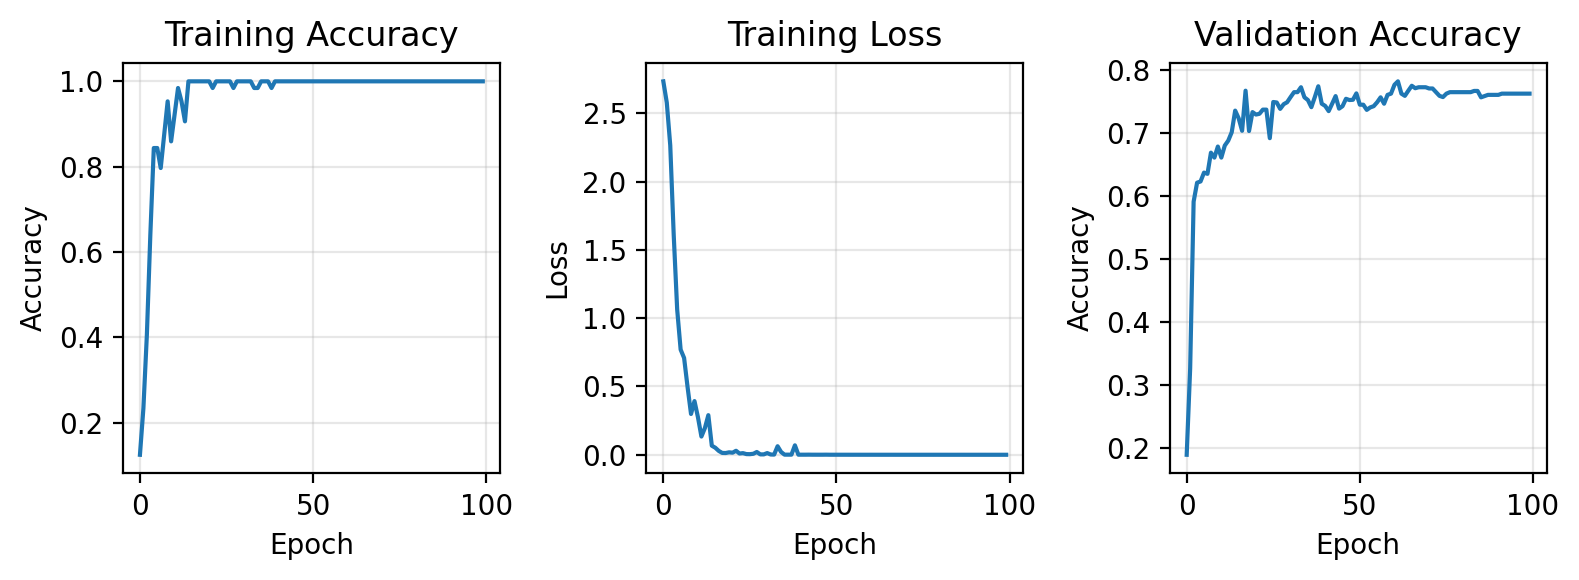

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200)

axes[0].set_title("Training Accuracy")
axes[0].plot(range(len(train_acc_history)),
             train_acc_history, label="Train Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Training Loss")
axes[1].plot(range(len(train_loss_history)),
             train_loss_history, label="Train Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True, alpha=0.3)

axes[2].set_title("Validation Accuracy")
axes[2].plot(range(len(val_acc_history)),
             val_acc_history, label="Validation Accuracy")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close(fig)

In [22]:
# 학습 모델 저장
PATH = "./models/KoBERT"
os.makedirs(PATH, exist_ok=True)

torch.save(model, os.path.join(PATH, "KoBERT.pt"))  # 전체 모델 저장
# 모델 객체의 state_dict 저장
torch.save(model.state_dict(), os.path.join(PATH, "model_state_dict.pt"))
torch.save(
    {"model": model.state_dict(), "optimizer": optimizer.state_dict()
     }, os.path.join(PATH, "all.tar")
)  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능